In [63]:
import os
import re
import numpy as np
from Bio import SeqIO

# Load VAE models

In [106]:
import numpy as np
import pytorch_lightning as pl
import torch
import torch.nn.functional as F

from models.vae_geometric import VAE, get_hparams, aa1_to_index, aa1

def get_data(data_filename, calc_weights=True, similarity_threshold=0.8):
    ids = []
    labels = []
    seqs = []
    label_re = re.compile(r'\[([^\]]*)\]')
    for record in SeqIO.parse(data_filename, "fasta"):
        ids.append(record.id)
        labels.append(label_re.search(record.description).group(1))
        seqs.append(np.array([aa1_to_index[aa] for aa in str(record.seq).upper().replace('.', '-')]))
        
    seqs = torch.from_numpy(np.vstack(seqs))
    labels = np.array(labels)

    weights = None
    if calc_weights is not False:
        one_hot = F.one_hot(seqs.long()).to('cuda' if torch.cuda.is_available() else 'cpu')
        one_hot[seqs>19] = 0
        flat_one_hot = one_hot.flatten(1)

        weights = []
        weight_batch_size = 1000
        flat_one_hot = flat_one_hot.float()
        for i in range(seqs.size(0) // weight_batch_size + 1):
            x = flat_one_hot[i * weight_batch_size : (i + 1) * weight_batch_size]
            similarities = torch.mm(x, flat_one_hot.T)
            lengths = (seqs[i * weight_batch_size : (i + 1) * weight_batch_size] <=19).sum(1).unsqueeze(-1).to('cuda' if torch.cuda.is_available() else 'cpu')
            w = 1.0 / (similarities / lengths).gt(similarity_threshold).sum(1).float()
            weights.append(w)
            # plt.hist(similarities/lengths)
            
        weights = torch.cat(weights)
        neff = weights.sum()

    return seqs, labels, weights

# Note that we deviate from the normal choice of 0.8 for the similarity threshold. This is 
# Due to the PFAM alignment being extremely long, with lots of positions matching gaps.
data, labels, weights = get_data("PF00144_full_labeled.fasta", calc_weights=True, similarity_threshold=0.6)
print(weights)

tensor([1.0000, 0.0500, 0.0333,  ..., 1.0000, 1.0000, 0.5000])


(array([1450., 1036., 1206.,  949.,  785.,  774.,  476.,  670.,  382.,
         410.,  473.,    0.,  587.,  691.,    0.,    0.,  853.,    0.,
           0., 1144.,    0.,    0.,    0.,    0., 1470.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0., 1980.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0., 3713.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        9344.]),
 array([0.00383142, 0.0137931 , 0.02375479, 0.03371647, 0.04367816,
        0.05363985, 0.06360153, 0.07356322, 0.08352491, 0.09348659,
        0.10344828, 0.11340996, 0.12337165, 0.13333334, 0.14329502

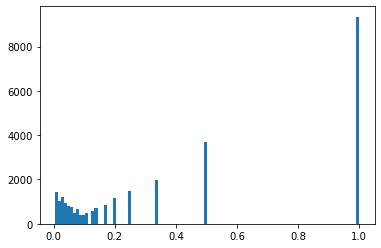

In [107]:
plt.hist(weights, bins=100)

In [108]:
import time
def train_or_retrieve_model(name, data, weights, train_model, uncertainty_temperature):
    
    cmd_args = []
    if train_model:
        cmd_args += ['-gpu', '1' if torch.cuda.is_available() else '']
    else:
        cmd_args += ['-load_from', name+'.ckpt', '-gpu', '1' if torch.cuda.is_available() else '']
    hparams = get_hparams(cmd_args)

    pl.seed_everything(hparams.seed)

    perm = np.random.permutation(data.shape[0])
    
    if hparams.load_from!='':
        
        if not os.path.exists(hparams.load_from):
            filename = os.path.join('https://sid.erda.dk/share_redirect/a5PTfl88w0/', hparams.load_from)
            !wget $filename
        
        print('Loading from checkpoint!')
        model = VAE.load_from_checkpoint(checkpoint_path=hparams.load_from, data=data, perm=perm, weights=weights)

        # for some reason these where not correctly saved in the checkpoint
        model.switch = True
        
        # Trigger retraining of distnet, since this does not seem to be saved properly in checkpoint
        model.distnet.initialized = False
        
        # Model fit specific parameter setting the temperature of the uncertainty
        model.distnet.trans.beta.data = torch.tensor([uncertainty_temperature])
        
    else:
        print('Training model!')
        model = VAE(data=data, weights=weights, perm=perm, hparams=hparams)
        trainer = pl.Trainer(gpus=1 if hparams.gpu else 0,
                             max_epochs=hparams.epochs)
        trainer.fit(model)
        
        trainer.save_checkpoint(name+'_{}.ckpt'.format(time.strftime("%Y%m%d")))

    return model

In [ ]:
# Options
train_models = True

# model_pf00144 = train_or_retrieve_model('model_PF00144', 
#                                         data,
#                                         weights=None,
#                                         train_model=train_models,
#                                         uncertainty_temperature=-3.5)
model_pf00144_reweighted = train_or_retrieve_model('model_PF00144_reweighted', 
                                                   data,
                                                   weights=weights,
                                                   train_model=train_models,
                                                   uncertainty_temperature=-3.5)
models = [model_pf00144, model_pf00144_reweighted]

Training model!


GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name          | Type             | Params
---------------------------------------------------
0 | encoder       | Sequential       | 91.7 M
1 | encoder_mu    | Linear           | 3.0 K 
2 | encoder_scale | Sequential       | 3.0 K 
3 | decoder       | Sequential       | 29.9 M
4 | loss_fn       | CrossEntropyLoss | 0     
5 | distnet       | DistNet          | 401   
---------------------------------------------------
121 M     Trainable params
400       Non-trainable params
121 M     Total params
/Users/wb/opt/miniconda3/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


/Users/wb/opt/miniconda3/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


In [ ]:
embeddings = []
for model in [model_pf00144, model_pf00144_reweighted]:
    embeddings.append([])
    batchsize = 16
    n_batch = int(np.ceil(model.data.shape[0] / batchsize))
    for b in range(n_batch):
        batch = model.data[b*batchsize:(b+1)*batchsize]
        zs = model.embedding(batch.long().to(model._device))
        embeddings[-1].append(zs.detach())
    embeddings[-1] = np.vstack(embeddings[-1])
    

    import matplotlib.pyplot as plt

# Color coding of organisms
colors = [[106,61,154],
          [254,192,113],
          [226,28,29],
          [250,155,153],
          [252,129,2],
          [168,206,227],
          [51,162,45],
          [179,225,139],
          [28,121,179],
          [193,193,193]]
colors = np.array(colors) / 255.0
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
for idx,_ in enumerate(embeddings):
    for i in range(len(phyla)):
        ax[idx].plot(embeddings[idx][labels==phyla[i],0],
                     embeddings[idx][labels==phyla[i],1],
                     '.', color=colors[i], label=phyla[i], markersize=1)    


# Preprocessing

In [71]:
# Options
run_preprocessing = False
n_sample = 500

phyla = ['Acidobacteria', 'Actinobacteria', 'Bacteroidetes',
         'Chloroflexi', 'Cyanobacteria', 'Deinococcus-Thermus',
         'Firmicutes', 'Fusobacteria', 'Proteobacteria']#, 'Other']

# # Data loading
# data = np.load('PF_LIST.npz', allow_pickle=True)['arr_0']
# aligned, seqs, labels, ids = [], [], [], []
# for d in data:
#     if d['label'] in phyla:
#         aligned.append(d['aligned'])
#         seqs.append(d['primary'])
#         labels.append(d['label'])
#         ids.append(d['id'])

# N = len(aligned)
# label_conv = dict([(k,v) for v,k in enumerate(np.unique(labels))])
# max_length_align = max([len(seq) for seq in aligned])
# max_length_seqs = max([len(seq) for seq in seqs])

# filter_idx, filter_lab, filter_N = [ ], [ ], 0
# for idx, lab in enumerate(labels):
#     if lab in phyla:
#         filter_idx.append(idx)
#         filter_lab.append(lab)
#         filter_N += 1
# print(len(filter_idx))
# print(len(ids))
# print(max(ids))
# print("***", len(data))
# print("****", max(filter_idx))
# print("*****", len(filter_idx))

# Retrieve Beta-lactamase alignment file. 
#if not os.path.exists('PF00144_full.txt'):
#    !wget https://sid.erda.dk/share_redirect/a5PTfl88w0/PF00144_full.txt
if not os.path.exists('PF00144_full_labeled.fasta'):
    !wget https://sid.erda.dk/share_redirect/a5PTfl88w0/PF00144_full_labeled.fasta

# Retrieve Beta-lactamase alignment file for which phyla labels could be extracted from Uniprot. 
if not os.path.exists('PF00144_full_length_sequences_labeled.fasta'):
        !wget https://sid.erda.dk/share_redirect/a5PTfl88w0/PF00144_full_length_sequences_labeled.fasta
            
ids = []
for record in SeqIO.parse('PF00144_full.txt', "fasta"):
    ids.append(record.id.split('/')[0])

filtered_ids = []
label_re = re.compile(r'\[([^\]]*)\]')
for record in SeqIO.parse('PF00144_full_length_sequences_labeled.fasta', "fasta"):
    label = label_re.search(record.description).group(1)
    if label in phyla:
        filtered_ids.append(record.id)

# print(ids[:10])    
# print(filtered_ids[:10])
    
filter_idx = []
for i,id in enumerate(filtered_ids):
    filter_idx.append(ids.index(id))
# print("****", max(filter_idx))
# print("*****", len(filter_idx))

print(len(filtered_ids))
#print(filter_idx)
    
if run_preprocessing:

    !FastTree > /dev/null
    if exit_code != 0:
                    
        # Attempt at making script self-contained by installing FastTree via conda. 
        # Seems to work on colab, but might not be super robust
        !conda --version
        if _exit_code != 0:
            !pip install -q condacolab
            import condacolab
            condacolab.install()
        
        !conda install -c bioconda fasttree 
    
    # Estimate tree
    !FastTree < PF00144_full.txt > PF00144_tree.txt

    sample_idx_i = np.random.choice(len(ids), n_sample)
    sample_idx_j = np.random.choice(len(ids), n_sample)

else:
    # Retrieve Beta-lactamase tree file
    if not os.path.exists('PF00144_tree.txt'):
        !wget https://sid.erda.dk/share_redirect/a5PTfl88w0/PF00144_tree.txt    
    
    # Retrieve indices sampled for paper
    if not os.path.exists('sample_i_j.npy'):
        !wget https://sid.erda.dk/share_redirect/a5PTfl88w0/sample_i_j.npy    
    
    sample_idx_i, sample_idx_j = np.load('sample_i_j.npy')


28393


In [65]:
try:
    from Bio import Phylo
except:
    !pip install biopython
    from Bio import Phylo

class TreeDist(object):
    def __init__(self, filename):
        self.tree = next(Phylo.parse(filename, 'newick'))
        self.leaves = list(self.tree.get_terminals())

    def id_to_id_dist(self, id1, id2):
        idx1, idx2 = -1, -1
        for i, leaf in enumerate(self.leaves):
            if id1 in leaf.name:
                idx1 = i
            if id2 in leaf.name:
                idx2 = i

        assert idx1 != -1, 'could not find id1: ' + id1
        assert idx2 != -1, 'could not find id2: ' + id2

        return self.tree.distance(self.leaves[idx1],
                                  self.leaves[idx2])
    
tree_dist = TreeDist("PF00144_tree.txt")

print("Leaves: ", len(tree_dist.leaves))

# dist_tree = []
# print('\n Calculating distances')
# for i, j in zip(sample_idx_i, sample_idx_j):
#     dist_tree.append(tree_dist.id_to_id_dist(ids[filter_idx[i]], ids[filter_idx[j]]))
# print(dist_tree)

Leaves:  36328


tensor([1., 1., 1.,  ..., 1., 1., 1.])


Training model!


GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name          | Type             | Params
---------------------------------------------------
0 | encoder       | Sequential       | 91.7 M
1 | encoder_mu    | Linear           | 3.0 K 
2 | encoder_scale | Sequential       | 3.0 K 
3 | decoder       | Sequential       | 29.9 M
4 | loss_fn       | CrossEntropyLoss | 0     
5 | distnet       | DistNet          | 401   
---------------------------------------------------
121 M     Trainable params
400       Non-trainable params
121 M     Total params
/Users/wb/opt/miniconda3/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


/Users/wb/opt/miniconda3/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


['Actinobacteria' 'Actinobacteria' 'Actinobacteria' ... 'Proteobacteria'
 'Actinobacteria' 'Bacteroidetes']


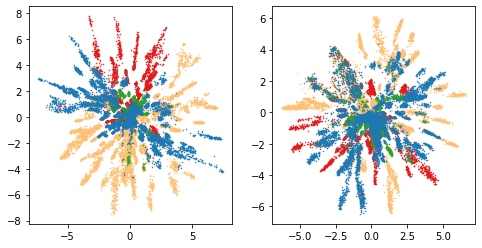

## Covariances

In [ ]:
phylo_distances